In [1]:
#import the basic libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn import svm
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
# libraries for SVM 
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

In [28]:
#import the dataset 
df = pd.read_csv('anemiaData.csv')
df.head()

,age,residence,highest_education,wealth_index,births_last5_years,age_respondent_1st_birth,hemoglobin_altitude_smoking,mother_anemia_level,mosquito_bed_sleeping,residing_husband_partner,fever_two_weeks,hemoglobin_altitude,child_anemia_level,iron_pills
0,25-29,Urban,Secondary,Richest,1,25,95.0,Moderate,Yes,Living with her,No,114,Not anemic,No
1,30-34,Urban,Higher,Richest,1,30,113.0,Mild,Yes,Living with her,No,119,Not anemic,No
2,35-39,Urban,Secondary,Richest,2,32,121.0,Not anemic,Yes,Living with her,No,102,Mild,Yes
3,20-24,Urban,Secondary,Richest,1,19,108.0,Moderate,Yes,Living with her,No,113,Not anemic,Yes
4,25-29,Urban,Higher,Richest,1,24,116.0,Mild,Yes,Living with her,No,109,Mild,No


In [29]:
#dimensions of the data 
df.shape

(10182, 14)

## In this section, we will be converting all our categorical data into numerical ordered data

In [30]:
df['age'] = df['age'].apply(lambda x: sum(int(i) for i in x.split('-')) / 2 if isinstance(x, str) else x)

In [31]:
le = LabelEncoder()


df['residence'] = le.fit_transform(df['residence'])
df['highest_education'] = le.fit_transform(df['highest_education'])
df['wealth_index'] = le.fit_transform(df['wealth_index'])
df['mother_anemia_level'] = le.fit_transform(df['mother_anemia_level'])
df['mosquito_bed_sleeping'] = le.fit_transform(df['mosquito_bed_sleeping'])
df['residing_husband_partner'] = le.fit_transform(df['residing_husband_partner'])
df['fever_two_weeks'] = le.fit_transform(df['fever_two_weeks'])
df['iron_pills'] = le.fit_transform(df['iron_pills'])
df['child_anemia_level'] = le.fit_transform(df['child_anemia_level'])

In [32]:
df.head(20)


,age,residence,highest_education,wealth_index,births_last5_years,age_respondent_1st_birth,hemoglobin_altitude_smoking,mother_anemia_level,mosquito_bed_sleeping,residing_husband_partner,fever_two_weeks,hemoglobin_altitude,child_anemia_level,iron_pills
0,27.0,1,3,4,1,25,95.0,1,1,0,1,114,2,1
1,32.0,1,0,4,1,30,113.0,0,1,0,1,119,2,1
2,37.0,1,3,4,2,32,121.0,2,1,0,1,102,0,2
3,22.0,1,3,4,1,19,108.0,1,1,0,1,113,2,2
4,27.0,1,0,4,1,24,116.0,0,1,0,1,109,0,1
5,22.0,1,0,4,2,19,118.0,0,1,0,1,96,1,2
6,22.0,1,0,4,2,19,118.0,0,1,0,1,111,2,1
7,27.0,1,0,4,2,22,134.0,2,1,0,1,117,2,1
8,27.0,1,3,4,2,22,95.0,1,1,0,1,96,1,2
9,27.0,1,3,4,2,22,95.0,1,1,0,1,106,0,2


### Our data is now completely numeric. However, we only want to predict a child's anemia level using the top 3 predictors from our random forest tree. 

### Hence we will drop all the data points other than: Hemoglobin_altitude, Hemoglobin_altitude_smoking and age_respondent_1st_birth

In [33]:
columns_to_drop = ['residence', 'highest_education', 'wealth_index', 'births_last5_years', 'age', 'mother_anemia_level','mosquito_bed_sleeping','residing_husband_partner','fever_two_weeks', 'iron_pills']
df.drop(columns_to_drop,axis =1, inplace = True)

In [34]:
df.shape

(10182, 4)

### Lets take a look at our new dataframe, consisting only of our top 3 predictors and a child's anemia level 

In [35]:
df.head()

,age_respondent_1st_birth,hemoglobin_altitude_smoking,hemoglobin_altitude,child_anemia_level
0,25,95.0,114,2
1,30,113.0,119,2
2,32,121.0,102,0
3,19,108.0,113,2
4,24,116.0,109,0


## We will now develop our SVM model 
### First we need to develop our train test split 

In [41]:
# Define feature matrix X by selecting all predictors
X = df.drop('child_anemia_level', axis=1)  # This removes the response variable from the feature matrix
# Define your target vector y by selecting the response variable
y = df['child_anemia_level']
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [42]:
# Prepare a pipeline to scale features
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

# Set up the parameter grid. In practice, you would expand this with a range of values.
param_grid = [
    {'svm__kernel': ['linear'], 'svm__C': [0.1, 1, 10]},
    {'svm__kernel': ['rbf'], 'svm__C': [0.1, 1, 10], 'svm__gamma': [0.01, 0.1, 1]},
    {'svm__kernel': ['poly'], 'svm__C': [0.1, 1, 10], 'svm__degree': [2, 3, 4]}
]

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Evaluate on the test set
y_test_pred = best_model.predict(X_test)
print(classification_report(y_test, y_test_pred))

Fitting 5 folds for each of 21 candidates, totalling 105 fits
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       552
           1       1.00      1.00      1.00       813
           2       1.00      1.00      1.00       617
           3       1.00      1.00      1.00        55

    accuracy                           1.00      2037
   macro avg       1.00      1.00      1.00      2037
weighted avg       1.00      1.00      1.00      2037



### From our gridsearch, we can tell that for the different kernels, the precision,recall and f1-scores are actually quite similar and does not tell us which kernel is the best 
### Hence we will be conducting more in-depth analysis for each kernel to determine which is the most suitable kernel 

In [43]:
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score

# Record the best scores and corresponding kernel
best_accuracy = 0
best_f1_score = 0
best_kernel = None

kernels = ['linear', 'poly', 'rbf', 'sigmoid']  # List the kernels you want to try
for kernel in kernels:
    # Create an SVM with the current kernel
    svm_model = make_pipeline(StandardScaler(), SVC(kernel=kernel))
    svm_model.fit(X_train, y_train)
    y_pred = svm_model.predict(X_test)
    
    # Calculate the accuracy and F1 score
    current_accuracy = accuracy_score(y_test, y_pred)
    current_f1_score = f1_score(y_test, y_pred, average='weighted')  
    print(f"Accuracy with the {kernel} kernel: {current_accuracy:.4f}")
    print(f"F1 score with the {kernel} kernel: {current_f1_score:.4f}")
    
    # Update the best scores and kernel if the current model is better
    if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy
        best_f1_score = current_f1_score
        best_kernel = kernel

print(f"The best kernel is {best_kernel} with an accuracy of {best_accuracy:.4f} and F1 score of {best_f1_score:.4f}")

Accuracy with the linear kernel: 0.9985
F1 score with the linear kernel: 0.9985
Accuracy with the poly kernel: 0.9210
F1 score with the poly kernel: 0.9228
Accuracy with the rbf kernel: 0.9917
F1 score with the rbf kernel: 0.9916
Accuracy with the sigmoid kernel: 0.7212
F1 score with the sigmoid kernel: 0.7234
The best kernel is linear with an accuracy of 0.9985 and F1 score of 0.9985


### From our data we can deduce that the kernel with the highest accuracy is a linear kernel, with an accuracy score of 0.9985. Hence, we will use a linear kernel for our model 
### We will now proceed to train our model

In [44]:
# as we had deducded 
kernel_to_use = 'linear'

# Initialize the StandardScaler
scaler = StandardScaler()

# Scale the features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the SVM with the selected kernel
svm_model = SVC(kernel=kernel_to_use)

# Create a pipeline that scales the data and then trains the model
pipeline = make_pipeline(StandardScaler(), SVC(kernel=kernel_to_use))

# Fit the model to the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test data
y_pred = pipeline.predict(X_test)

In [45]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Generate a full classification report
report = classification_report(y_test, y_pred)
print(report)

Accuracy: 0.9985
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       552
           1       1.00      1.00      1.00       813
           2       1.00      1.00      1.00       617
           3       1.00      1.00      1.00        55

    accuracy                           1.00      2037
   macro avg       1.00      1.00      1.00      2037
weighted avg       1.00      1.00      1.00      2037



### What do these numbers mean? 
#### With a high accuracy score of 0.9985, this indicates our model correctly predicted the class accurately 99.85% of the time
#### From our precision scores, it is also evident that there were no false positives across all the classes, indicating a highly accurate model 
#### From our recall scores, we can tell that for all levels, there were no false negatives.
#### From our f1-score, we can also infer that across the anemia levels, our model has a good standard of precision and recall.
#### Hence, these numbers indicates that our model is highly accurate 

#### However, a highly accurate model may sometimes imply that our training data is overfitted. Hence, let us see if our data is overfitted


Cross-validation scores: [0.99815838 1.         1.         0.99877225 1.        ]


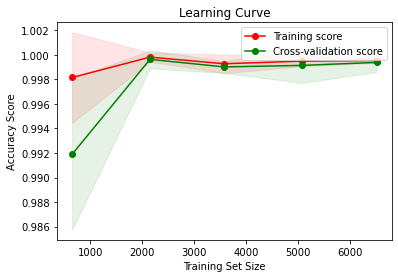

In [46]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# Cross-validation scores
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5)
print(f'Cross-validation scores: {cv_scores}')

# Learning curves
train_sizes, train_scores, validation_scores = learning_curve(
    pipeline, X_train, y_train, train_sizes=[0.1, 0.33, 0.55, 0.78, 1.0], cv=5)

# Mean and standard deviation of training and validation scores
train_scores_mean = train_scores.mean(axis=1)
validation_scores_mean = validation_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
validation_scores_std = validation_scores.std(axis=1)

# Plot learning curves
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.show()

## Just like our previous model, we used a few strategies to check for overfitting and ensuring our model is not overfitted
### 1. Cross Validation Scores - The cross validation scores across all subsets of the data was very high, thus implying that our model is stable and generalises well to the data 

### 2.Learning curve - A learning curve plot shows the relationship between our accuracy score and training set size. The accuracy of our training score and cross validation score increases as we approach 2000 in training set size, and remains relatively accurate as the training size increases, fluctuating between 0.998 to 1.000


## What can we conclude: 
### 1. Our model is not overfitted. From our graph, it is obvious that the gap between the training and cross validation scores were quite narrow, implying that there is no overfitting 
### 2. Our model becomes relatively stable pas the 2000 data points mark. This is seen from how accuracy score remains relatively similar 

### Hence, we can use this model to make even more accurate predictions on a child's anemia level


## In this section, we will be using our model to predict the child's anemia level 

In [51]:
#Get the user to input their values to predict their anemia level 
age = int(input("How old was the mother when she gave birth? "))
hemoglobin_altitude = float(input("Enter the hemoglobin level at the altitude level"))
hemoglobin_smoking = float(input("Enter the hemoglobin level adjusted to smoking and altitude levels?"))

#Combine the user input into a single array 
new_data_point = np.array([age,hemoglobin_altitude,hemoglobin_smoking]).reshape(1,-1)

new_data_point_scaled = scaler.transform(new_data_point)

predicted_anemia_level = pipeline.predict(new_data_point_scaled)

print(f"The predicted anemia level is: {predicted_anemia_level[0]}")


How old was the mother when she gave birth? 32
Enter the hemoglobin level at the altitude level102
Enter the hemoglobin level adjusted to smoking and altitude levels?121
The predicted anemia level is: 3
